In [2]:
# 현재 파일은 손글씨 분류 문제를 위한 파일입니다.

# 모듈 불러오기
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
# GPU 사용 여부
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

print('current device is :', device)

current device is : cpu


In [10]:
# 하이퍼 파라미터 지정하기
batch_size = 50
epoch_num = 15
learning_rate = 0.0001


In [6]:
# Mnist 데이터셋 불러오기
train_data = datasets.MNIST(root='../../dataset/hands_writing_data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST(root='../../dataset/hands_writing_data', train=False, download=True, transform=transforms.ToTensor())

print(len(train_data))
print(len(test_data))

9.6%

100.0%


Extracting ../../dataset/hands_writing_data/MNIST/raw/train-images-idx3-ubyte.gz to ../../dataset/hands_writing_data/MNIST/raw



100.0%
57.6%

Extracting ../../dataset/hands_writing_data/MNIST/raw/train-labels-idx1-ubyte.gz to ../../dataset/hands_writing_data/MNIST/raw



100.0%
100.0%


Extracting ../../dataset/hands_writing_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../dataset/hands_writing_data/MNIST/raw

Extracting ../../dataset/hands_writing_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../dataset/hands_writing_data/MNIST/raw

60000
10000


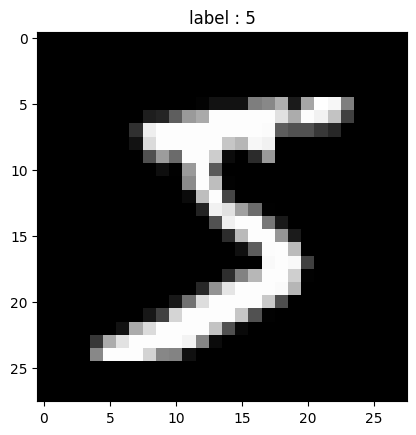

In [49]:
# 데이터 세트 확인하기
image, label = train_data[0]

plt.imshow(image.squeeze().numpy(), cmap='gray')
plt.title('label : %s' % label)
plt.show()

In [11]:
# 미니배치 구성하기
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

first_batch = train_loader.__iter__().__next__()
print('{:15s} | {:<25s} | {}'.format('name', 'type', 'size'))

name            | type                      | size


In [12]:
# 간단한 CNN을 사용한다.
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


In [13]:
# Optimizer 및 손실함수 정의
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()


In [14]:
print(model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [15]:
model.train()
i = 0
for epoch in range(epoch_num):
    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if i % 1000 == 0:
            print('Train Step: {}\tLoss : {:.3f}'.format(i, loss.item()))
        i+=1

/Users/parkminseo/miniconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Train Step: 0	Loss : 2.325
Train Step: 1000	Loss : 0.206
Train Step: 2000	Loss : 0.095
Train Step: 3000	Loss : 0.198
Train Step: 4000	Loss : 0.076
Train Step: 5000	Loss : 0.075
Train Step: 6000	Loss : 0.103
Train Step: 7000	Loss : 0.041
Train Step: 8000	Loss : 0.038
Train Step: 9000	Loss : 0.028
Train Step: 10000	Loss : 0.032
Train Step: 11000	Loss : 0.008
Train Step: 12000	Loss : 0.105
Train Step: 13000	Loss : 0.045
Train Step: 14000	Loss : 0.040
Train Step: 15000	Loss : 0.124
Train Step: 16000	Loss : 0.009
Train Step: 17000	Loss : 0.012


In [17]:
# 모델 평가
model.eval()
correct = 0
for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)
    output = model(data)
    prediction = output.data.max(1)[1]
    correct += prediction.eq(target.data).sum()
print('Test set: Accuracy: {:.2f}%'.format(100 * correct / len(test_loader.dataset)))

/Users/parkminseo/miniconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Test set: Accuracy: 98.93%


In [18]:
# 모델 저장하기

MODEL_SAVE_PATH = './writing_model.pt'
torch.save(model, MODEL_SAVE_PATH)

In [56]:
model = torch.load(MODEL_SAVE_PATH)

model.eval()

def get_prediction(image_bytes):
    print(image_bytes.shape)
    outputs = model.forward(image_bytes)
    _, y_hat = outputs.max(1)
    prediction = y_hat.item()
    return prediction

get_prediction(train_data[2][0].unsqueeze(0))

torch.Size([1, 1, 28, 28])


4

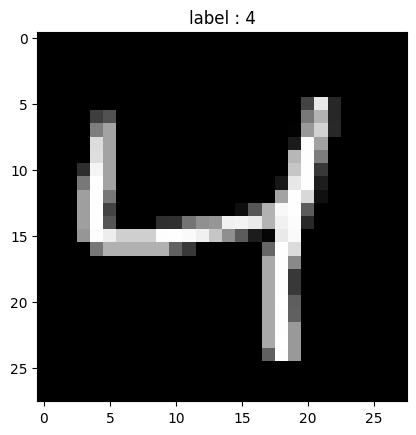

In [48]:
# 데이터 세트 확인하기
image, label = train_data[2]

plt.imshow(image.squeeze().numpy(), cmap='gray')
plt.title('label : %s' % label)
plt.show()

In [54]:
print(image.squeeze(0).numpy().shape)

(28, 28)


In [55]:
print(type(image.squeeze(0).numpy().shape))

<class 'tuple'>
